In [ ]:
import pandas as pd
# Import any data cleaning libraries here

# Import your selected models here

# Import any other libraries here
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import folium
import json
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
!pip install folium --upgrade
import folium.plugins # The Folium Javascript Map Library
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# LEGALST 123 Problem Set 2: NY Arraignment Flight Risk Prediction

In [ ]:
np.random.seed(0)

# Data Cleaning

A. Leakage for one could occur here if we utilize multiple columns that contain the same or very similar information, or whose information implicitly relates to another, as predictor variables, e.g. the arrest and arraign charges. Moreover, this could occur if some rows overlap between the data set and the training set or if the data is not independent and identically distributed. Moreover, leakage occurs if the dataset contains information that was not actually available at arraignment when the judge made decisions on defendant flight risk. Columns that contain information that was only available later are "Top_Arrest_Law", "Top_Arrest_Article_Section", "Top_Arrest_Attempt_Indicator", "Top_Charge_at_Arrest", "Top_Charge_Severity_at_Arrest", "Top_Charge_Weight_at_Arrest", and "Top_Charge_at_Arrest_Violent_Felony_Ind". Same goes for 

## Load Dataset
Load your dataset. Consider which columns you need for the analysis.

In [ ]:
# II b

url = "https://www.nycourts.gov/legacypdfs/court-research/PretrialReleaseDataExtractWeb.zip"
data = pd.read_csv(url, index_col=0)

I only imported the columns that I can possibly for the regression in the following cell. I ignored all columns that would split into many columns once I conduct OHE. Additionally, I ignored all data that a judge does not have information to since our purpose is to prior to making a decision since we aim to create a model that predicts decisions based on the information that a judge has access to. 

In [ ]:
# Reseting the index to avoid problems later and selecting the columns that I will focus on
data = data.reset_index()
data = data[["Remanded_to_Jail_at_Arraign", "First_Arraign_Date", "Gender", "Race", "Ethnicity", "Age_at_Crime", "Top_Arraign_Attempt_Indicator", "Top_Severity_at_Arraign", "Top_Charge_at_Arraign_Violent_Felony_Ind", "prior_vfo_cnt", "prior_nonvfo_cnt", "prior_misd_cnt"  ]]

In [ ]:
data

,Remanded_to_Jail_at_Arraign,First_Arraign_Date,Gender,Race,Ethnicity,Age_at_Crime,Top_Arraign_Attempt_Indicator,Top_Severity_at_Arraign,Top_Charge_at_Arraign_Violent_Felony_Ind,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt
0,N,2020-03-01,Female,Black,Unknown,29,NaN,Misdemeanor,N,0.0,0.0,0.0
1,N,2020-05-01,Male,Black,Non Hispanic,29,NaN,Misdemeanor,N,0.0,1.0,1.0
2,N,2020-07-01,Female,White,Hispanic,22,NaN,Felony,Y,0.0,0.0,0.0
3,N,2021-08-01,Female,Unknown,Unknown,33,NaN,Misdemeanor,N,NaN,NaN,NaN
4,N,2021-02-01,Male,Black,Non Hispanic,49,NaN,Felony,N,0.0,3.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
582976,N,2020-07-01,Male,Black,Non Hispanic,17,NaN,Felony,N,0.0,0.0,0.0
582977,N,2020-07-01,Male,Black,Non Hispanic,16,NaN,Felony,N,0.0,0.0,0.0
582978,N,2020-07-01,Male,Black,Non Hispanic,17,NaN,Felony,Y,NaN,NaN,NaN
582979,N,2020-07-01,Male,White,Non Hispanic,16,NaN,Felony,N,0.0,0.0,0.0


I initially was planning on using the demographic information for later questions, the temporal information to filter for the right timeframe, and the arraignment charges as well as the prior crimes as predictor variables. Many columns in the arraignment charges would, however, blow up the dataframe when I ohe them. Hence, I decided to forgo those. This left me with these columns.  

In [ ]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582981 entries, 0 to 582980
Data columns (total 12 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Remanded_to_Jail_at_Arraign               582981 non-null  object 
 1   First_Arraign_Date                        582981 non-null  object 
 2   Gender                                    582981 non-null  object 
 3   Race                                      582981 non-null  object 
 4   Ethnicity                                 582981 non-null  object 
 5   Age_at_Crime                              582981 non-null  int64  
 6   Top_Arraign_Attempt_Indicator             11536 non-null   object 
 7   Top_Severity_at_Arraign                   582981 non-null  object 
 8   Top_Charge_at_Arraign_Violent_Felony_Ind  582981 non-null  object 
 9   prior_vfo_cnt                             498553 non-null  float64
 10  prior_nonvfo_cnt    

,Remanded_to_Jail_at_Arraign,First_Arraign_Date,Gender,Race,Ethnicity,Age_at_Crime,Top_Arraign_Attempt_Indicator,Top_Severity_at_Arraign,Top_Charge_at_Arraign_Violent_Felony_Ind,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt
0,N,2020-03-01,Female,Black,Unknown,29,NaN,Misdemeanor,N,0.0,0.0,0.0
1,N,2020-05-01,Male,Black,Non Hispanic,29,NaN,Misdemeanor,N,0.0,1.0,1.0
2,N,2020-07-01,Female,White,Hispanic,22,NaN,Felony,Y,0.0,0.0,0.0
3,N,2021-08-01,Female,Unknown,Unknown,33,NaN,Misdemeanor,N,NaN,NaN,NaN
4,N,2021-02-01,Male,Black,Non Hispanic,49,NaN,Felony,N,0.0,3.0,10.0


In [ ]:
# Checking which columns contain null values 
for col in data.columns:
    null_count = data[col].isnull().sum()
    print(col)
    print(null_count)

Remanded_to_Jail_at_Arraign
0
First_Arraign_Date
0
Gender
0
Race
0
Ethnicity
0
Age_at_Crime
0
Top_Arraign_Attempt_Indicator
571445
Top_Severity_at_Arraign
0
Top_Charge_at_Arraign_Violent_Felony_Ind
0
prior_vfo_cnt
84428
prior_nonvfo_cnt
84428
prior_misd_cnt
84428


Inspecing the columns that have null values to see why they might have table





In [ ]:
null_cols = data.columns[data.isnull().any()]

data_null_cols = data[null_cols]

print(data_null_cols)

       Top_Arraign_Attempt_Indicator  prior_vfo_cnt  prior_nonvfo_cnt  \
0                                NaN            0.0               0.0   
1                                NaN            0.0               1.0   
2                                NaN            0.0               0.0   
3                                NaN            NaN               NaN   
4                                NaN            0.0               3.0   
...                              ...            ...               ...   
582976                           NaN            0.0               0.0   
582977                           NaN            0.0               0.0   
582978                           NaN            NaN               NaN   
582979                           NaN            0.0               0.0   
582980                           NaN            0.0               0.0   

        prior_misd_cnt  
0                  0.0  
1                  1.0  
2                  0.0  
3                  NaN 

Top_Arraign_Attempt_Indicator has blanks if there is not attempt. Hence we can just replace those with None. In the case of the prior columns, those are most likely NaN because there are no prior ones. Hence, I will replace those with 0.



In [ ]:
clean_data = data
clean_data["prior_vfo_cnt"] = clean_data["prior_vfo_cnt"].fillna(0)
clean_data["prior_nonvfo_cnt"] = clean_data["prior_nonvfo_cnt"].fillna(0)
clean_data["prior_misd_cnt"] = clean_data["prior_misd_cnt"].fillna(0)
clean_data["Top_Arraign_Attempt_Indicator"] = clean_data["Top_Arraign_Attempt_Indicator"].fillna("None")

In [ ]:
clean_null_cols = clean_data.columns[clean_data.isnull().any()]

clean_data_null_cols = clean_data[clean_null_cols]

print("Columns with null values:")
print(clean_data_null_cols)

Columns with null values:
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[582981 rows x 0 columns]


There are no null values left as tested by the last cell. Hence, we can move on.

# II D. 
We are interested in the timeframe after July 1st 2020 since that is the date of the reform. Hence, we should drop all data before this date. We do so by filtering by First Arraign Date and dropping all rows where this date is before July 1st 2020. 

In [ ]:
# Implementing this

clean_data['First_Arraign_Date'] = pd.to_datetime(clean_data['First_Arraign_Date'], format='%Y-%m-%d')

clean_data_filtered = clean_data[clean_data['First_Arraign_Date'] >= pd.Timestamp('2020-07-01')]

In [ ]:
# II E. 
# I will do this later because I will drop some rows and do some editing. Splitting before would lead to me not doing these edits on only a fraction of the dataset

#X_train, X_test, y_train, y_test = train_test_split(clean_data_filtered[["prior_vfo_cnt", "prior_nonvfo_cnt", "prior_misd_cnt"]], clean_data_filtered["Remanded_to_Jail_at_Arraign"], train_size=0.80, test_size=0.20, random_state=42)
#X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.75, test_size=0.25, , random_state=42)

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_validate = scaler.transform(X_validate)
#X_test = scaler.transform(X_test)

In [ ]:
# It turns out that Top_Severity_at_Arraign has a couple of values that are not Felony or Misdemeanor but just spaces. 
clean_data_filtered["Top_Severity_at_Arraign"].unique()

array(['Felony', 'Misdemeanor', ' '], dtype=object)

In [ ]:
# Finding the number of these ccases
sum(clean_data_filtered["Top_Severity_at_Arraign"] == " ")

1737

In [ ]:
# Since these are omly 1737 columns, I will drop these (which is fine since we have hundreds of thousands of columns)

clean_data_filtered = clean_data_filtered[clean_data_filtered["Top_Severity_at_Arraign"] != " "]

In [ ]:
sum(clean_data_filtered["Top_Severity_at_Arraign"] == " ")

0

In [ ]:
# III. A 
# Changing some object columns into numerical data for feature selection
# My feature selection will be based on correlation. I will choose the features that have the highest correlation with Remanded_to_Jail_at_Arraign because high correlation will late render the regression more accurate 

clean_data_filtered["Remanded_to_Jail_at_Arraign"] = clean_data_filtered["Remanded_to_Jail_at_Arraign"].replace({"Y": 1, "N": 0})
clean_data_filtered["Top_Charge_at_Arraign_Violent_Felony_Ind"] = clean_data_filtered["Top_Charge_at_Arraign_Violent_Felony_Ind"].replace({"Y": 1, "N": 0})
clean_data_filtered["Top_Severity_at_Arraign"] = clean_data_filtered["Top_Severity_at_Arraign"].replace({"Felony": 1, "Misdemeanor": 0})
clean_data_filtered["Top_Arraign_Attempt_Indicator"] = clean_data_filtered["Top_Arraign_Attempt_Indicator"].replace({"Attempt": 1, "None": 0})

In [ ]:
clean_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488835 entries, 2 to 582980
Data columns (total 12 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   Remanded_to_Jail_at_Arraign               488835 non-null  int64         
 1   First_Arraign_Date                        488835 non-null  datetime64[ns]
 2   Gender                                    488835 non-null  object        
 3   Race                                      488835 non-null  object        
 4   Ethnicity                                 488835 non-null  object        
 5   Age_at_Crime                              488835 non-null  int64         
 6   Top_Arraign_Attempt_Indicator             488835 non-null  int64         
 7   Top_Severity_at_Arraign                   488835 non-null  int64         
 8   Top_Charge_at_Arraign_Violent_Felony_Ind  488835 non-null  int64         
 9   prior_vfo_cnt  

In [ ]:
# III. A 
# Creating an extra dataset in order to avoid messing up the first one. This dataset will include demographic information whereas the other one wont 
clean_data_filtered_v2 = clean_data_filtered[["Age_at_Crime", "Ethnicity", "Remanded_to_Jail_at_Arraign", "Gender", "Race", "Top_Severity_at_Arraign", "Top_Charge_at_Arraign_Violent_Felony_Ind", "prior_vfo_cnt",	"prior_nonvfo_cnt",	"prior_misd_cnt", "Top_Arraign_Attempt_Indicator"]]

In [ ]:
# III. A 
# Changing the objects to categories with numerical values
for col in clean_data_filtered_v2.columns:
    if clean_data_filtered_v2[col].dtype == 'object':
        clean_data_filtered_v2[col] = clean_data_filtered_v2[col].astype('category').cat.codes
clean_data_filtered_v2

,Age_at_Crime,Ethnicity,Remanded_to_Jail_at_Arraign,Gender,Race,Top_Severity_at_Arraign,Top_Charge_at_Arraign_Violent_Felony_Ind,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,Top_Arraign_Attempt_Indicator
2,22,0,0,0,5,1,1,0.0,0.0,0.0,0
3,33,2,0,0,4,0,0,0.0,0.0,0.0,0
4,49,1,0,1,2,1,0,0.0,3.0,10.0,0
5,24,1,0,1,2,1,0,0.0,0.0,0.0,0
6,23,1,0,1,2,0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
582976,17,1,0,1,2,1,0,0.0,0.0,0.0,0
582977,16,1,0,1,2,1,0,0.0,0.0,0.0,0
582978,17,1,0,1,2,1,1,0.0,0.0,0.0,0
582979,16,1,0,1,5,1,0,0.0,0.0,0.0,0


,Age_at_Crime,Ethnicity,Remanded_to_Jail_at_Arraign,Gender,Race,Top_Severity_at_Arraign,Top_Charge_at_Arraign_Violent_Felony_Ind,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,Top_Arraign_Attempt_Indicator
Age_at_Crime,1.000000,0.013294,0.006524,-0.004794,0.059879,-0.086976,-0.125684,0.153814,0.304851,0.333538,-0.025454
Ethnicity,0.013294,1.000000,0.007746,-0.047267,-0.100490,-0.138304,-0.113148,-0.070738,-0.075125,-0.076746,-0.040486
Remanded_to_Jail_at_Arraign,0.006524,0.007746,1.000000,0.058364,-0.031462,0.242910,0.179193,0.113456,0.151870,0.097835,0.057687
Gender,-0.004794,-0.047267,0.058364,1.000000,-0.044172,0.086315,0.066038,0.150133,0.147437,0.114705,0.019307
Race,0.059879,-0.100490,-0.031462,-0.044172,1.000000,-0.092708,-0.136371,-0.164457,-0.094614,-0.069498,-0.034558
Top_Severity_at_Arraign,-0.086976,-0.138304,0.242910,0.086315,-0.092708,1.000000,0.592038,0.112905,0.115673,0.087000,0.124773
Top_Charge_at_Arraign_Violent_Felony_Ind,-0.125684,-0.113148,0.179193,0.066038,-0.136371,0.592038,1.000000,0.082511,0.005430,-0.017567,0.156205
prior_vfo_cnt,0.153814,-0.070738,0.113456,0.150133,-0.164457,0.112905,0.082511,1.000000,0.322502,0.329720,0.026325
prior_nonvfo_cnt,0.304851,-0.075125,0.151870,0.147437,-0.094614,0.115673,0.005430,0.322502,1.000000,0.615660,0.010154
prior_misd_cnt,0.333538,-0.076746,0.097835,0.114705,-0.069498,0.087000,-0.017567,0.329720,0.615660,1.000000,0.005767


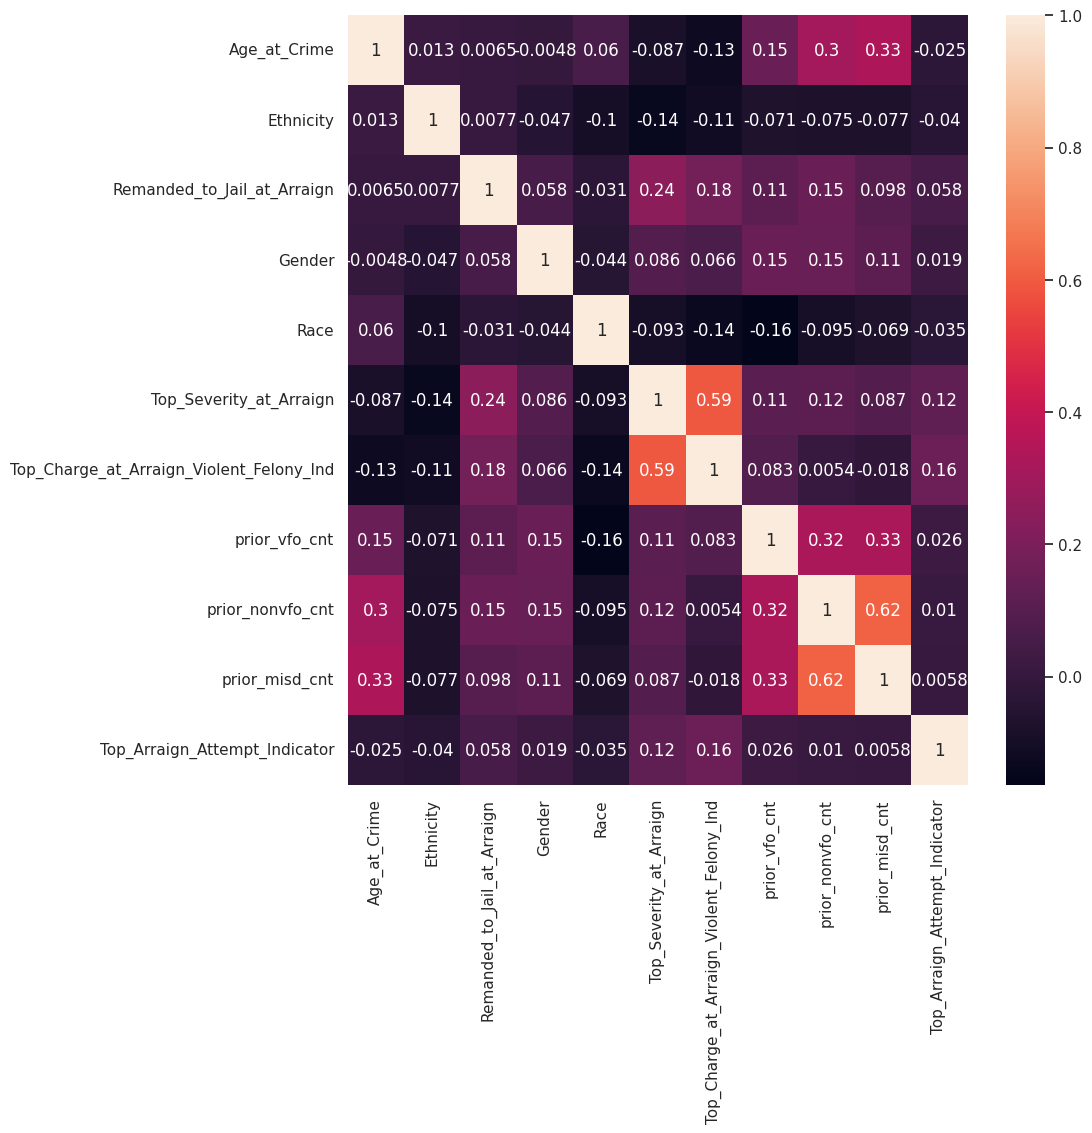

In [ ]:
# III. A Creating a heatmap to anaylsze the correlation between all these factors and Remanded_to_Jail_Arraign. A heatmap is helpful because it enables one to see all correlations in one organized and concise manner. I believe that studying the correlation between potential indicators and Remanded_to_Jail_at_Arraign is the best methodology because correlation is the key determinant to creating a regression because a regression is fundamentally about finding factors that can predict a certain outcome, which is Remanded_to_Jail_at_Arraign here.
corrmat = clean_data_filtered_v2[["Age_at_Crime", "Ethnicity", "Remanded_to_Jail_at_Arraign", "Gender", "Race", "Top_Severity_at_Arraign", "Top_Charge_at_Arraign_Violent_Felony_Ind", "prior_vfo_cnt",	"prior_nonvfo_cnt",	"prior_misd_cnt", "Top_Arraign_Attempt_Indicator"]].corr()
plt.figure(figsize=(10,10))
g = sns.heatmap(corrmat, annot=True)
corrmat

Top_Severity_at_Arriagn has the highest correlation with 0.24, followed by Top__Charge_at_Arraign_Violent_Felony_Ind with 0.18, prior_nonvfo_cnt with 0.15, and prior_vfo_cnt with 0.11.   

In [ ]:
# III. A 
# Based on the last graph race, gender, and age seem to not have a large impact. In this and the following cell, I will encode the age, race, and gender into binary columns in order to make sure that this holds. Age will be 1 if it is above the median age and 0 otherwise. Gender will be 1 for male, 0 for female, and 2 for other options. Race will be 1 for black and 0 for non-black.
median_age = np.median(clean_data_filtered_v2["Age_at_Crime"])
median_age

32.0

In [ ]:
# III. A 
clean_data_filtered_v3 = clean_data_filtered_v2

clean_data_filtered_v3["Age_at_Crime"] = clean_data_filtered_v3["Age_at_Crime"].apply(lambda x: 1 if x > int(median_age) else 0)
clean_data_filtered_v3["Race"] = clean_data_filtered_v3["Race"].apply(lambda x: 1 if x == 2 else 0)
clean_data_filtered_v3.head()

,Age_at_Crime,Ethnicity,Remanded_to_Jail_at_Arraign,Gender,Race,Top_Severity_at_Arraign,Top_Charge_at_Arraign_Violent_Felony_Ind,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,Top_Arraign_Attempt_Indicator
2,0,0,0,0,0,1,1,0.0,0.0,0.0,0
3,1,2,0,0,0,0,0,0.0,0.0,0.0,0
4,1,1,0,1,1,1,0,0.0,3.0,10.0,0
5,0,1,0,1,1,1,0,0.0,0.0,0.0,0
6,0,1,0,1,1,0,0,0.0,0.0,0.0,0


,Age_at_Crime,Ethnicity,Remanded_to_Jail_at_Arraign,Gender,Race,Top_Severity_at_Arraign,Top_Charge_at_Arraign_Violent_Felony_Ind,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,Top_Arraign_Attempt_Indicator
Age_at_Crime,1.000000,0.008950,0.019047,0.003300,-0.066583,-0.059748,-0.102956,0.123708,0.271683,0.306006,-0.020002
Ethnicity,0.008950,1.000000,0.007746,-0.047267,-0.075977,-0.138304,-0.113148,-0.070738,-0.075125,-0.076746,-0.040486
Remanded_to_Jail_at_Arraign,0.019047,0.007746,1.000000,0.058364,0.046716,0.242910,0.179193,0.113456,0.151870,0.097835,0.057687
Gender,0.003300,-0.047267,0.058364,1.000000,0.044628,0.086315,0.066038,0.150133,0.147437,0.114705,0.019307
Race,-0.066583,-0.075977,0.046716,0.044628,1.000000,0.146707,0.169625,0.202995,0.143080,0.129249,0.043688
Top_Severity_at_Arraign,-0.059748,-0.138304,0.242910,0.086315,0.146707,1.000000,0.592038,0.112905,0.115673,0.087000,0.124773
Top_Charge_at_Arraign_Violent_Felony_Ind,-0.102956,-0.113148,0.179193,0.066038,0.169625,0.592038,1.000000,0.082511,0.005430,-0.017567,0.156205
prior_vfo_cnt,0.123708,-0.070738,0.113456,0.150133,0.202995,0.112905,0.082511,1.000000,0.322502,0.329720,0.026325
prior_nonvfo_cnt,0.271683,-0.075125,0.151870,0.147437,0.143080,0.115673,0.005430,0.322502,1.000000,0.615660,0.010154
prior_misd_cnt,0.306006,-0.076746,0.097835,0.114705,0.129249,0.087000,-0.017567,0.329720,0.615660,1.000000,0.005767


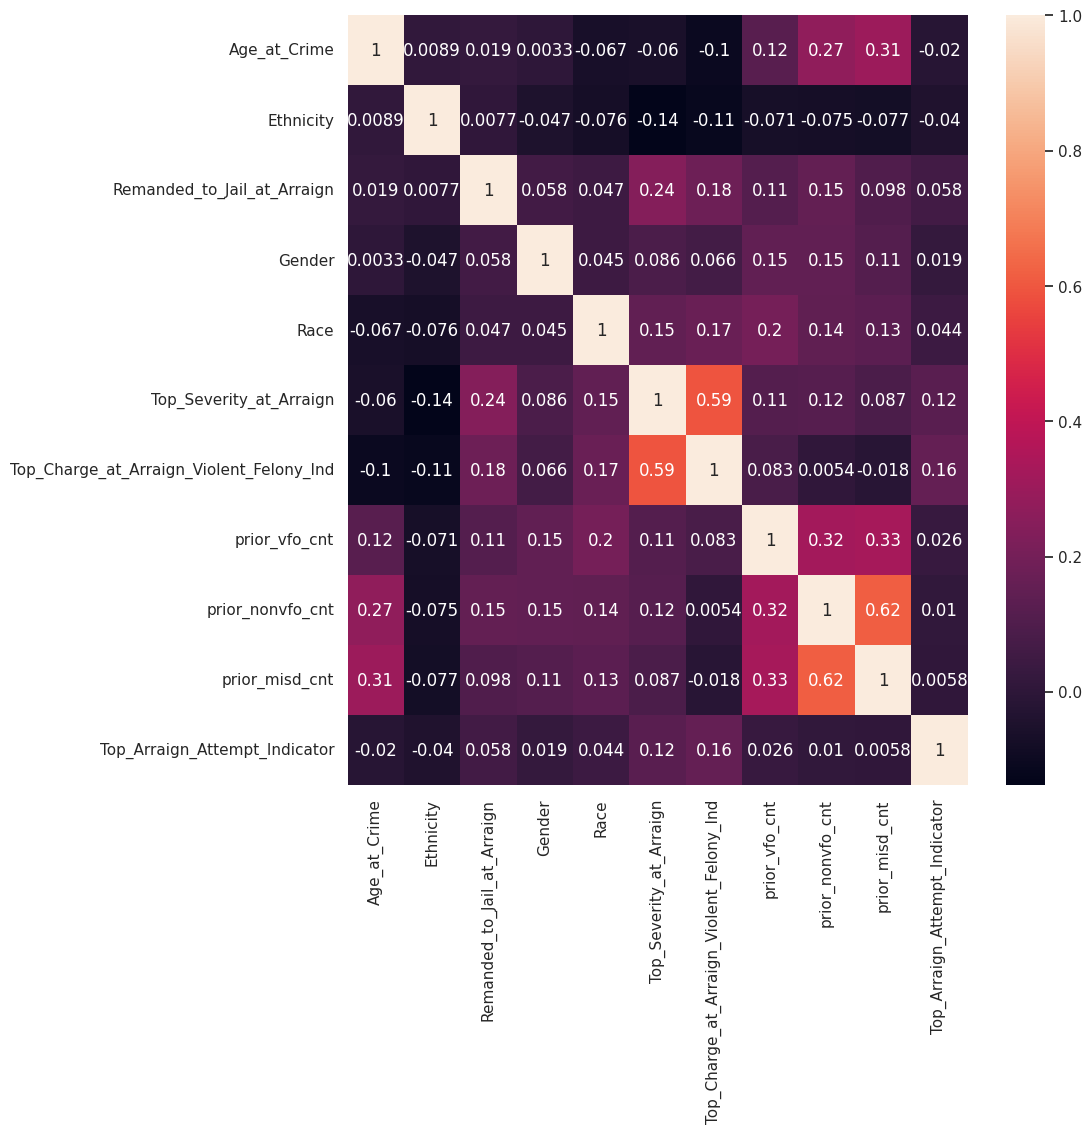

In [ ]:
# III. A 
corrmat = clean_data_filtered_v3[["Age_at_Crime", "Ethnicity", "Remanded_to_Jail_at_Arraign", "Gender", "Race", "Top_Severity_at_Arraign", "Top_Charge_at_Arraign_Violent_Felony_Ind", "prior_vfo_cnt",	"prior_nonvfo_cnt",	"prior_misd_cnt", "Top_Arraign_Attempt_Indicator"]].corr()
plt.figure(figsize=(10,10))
g = sns.heatmap(corrmat, annot=True)
corrmat

Encoding race and age into binary values increases their correlation with Remanded_to_Jail_at_Arraign. In the case of age, it increases the correlation by almost an order of magnitude. Hence, I will utilize these transformed columns. 

#III B

Based on the prior matrix, prior_nonvfo_cnt, prior_vfo_cnt, and Top_Severity_at_Arraign are the three columns with the highest correlation. Hence, I would chose these ones if I could only chose three. Additionally, I know for a fact that they do not have leakage. Moreover, I know for certain that the judges have this information before the trial. Additionally, all of these factors should in theory have an impact on the judges decision. Intuitively, Top_Severity_at_Arraign is crucial because the worse the crime is the more likely somebody should be to be detained. Arguably, this should be the most important factor in determining whether someone should be detained because firstly there should be a large penalty for a worse crime. Secondly, somebody who committs a worse crime is also more dangerous to the public. prior_vfo_cnt is crucial by a similar logic. Somebody that has committed felonies before should be more likely to be detained because by logic and statistics, somebody who has already committed crimes earlier is more likely to reoffend (and probably more likely to be guilty) and, hence, is more dangerous to the public. I would chose felonies over misdemeanors because felonies are worse and, hence, a better indicator of whether somebody should be detained. Same goes for prior_nonvfo_cnt. Violent misdemeanors are probably better indicators but I believe that both are such great indictors that it is worth to have both of them. In fact, I believe fundamentally that nothing is a better indicator of whether somebody should be detained than their past history (which is given by prior_nonvfo_cnt and prior_vfo_cnt) and the severity of their crime.   

In [ ]:
# IV A

y = clean_data_filtered_v3["Remanded_to_Jail_at_Arraign"]
X = clean_data_filtered_v3[["prior_vfo_cnt", "prior_nonvfo_cnt", "prior_misd_cnt", "Top_Charge_at_Arraign_Violent_Felony_Ind", "Top_Arraign_Attempt_Indicator", "Top_Severity_at_Arraign", "Race", "Gender", "Age_at_Crime"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.2, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

In [ ]:
# IV A

model = LogisticRegression()

logistic_reg = model.fit(X_train, y_train)

y_pred = logistic_reg.predict(X_train)

num_correct = np.sum(y_pred == y_train)
num_total = len(y_train)
accuracy = num_correct / num_total

print("Test set accuracy:", accuracy)

conf_matrix = confusion_matrix(y_train, y_pred)
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, None]

print("Normalized confusion matrix:\n", conf_matrix_norm)

Test set accuracy: 0.965796206488356
Normalized confusion matrix:
 [[9.99641430e-01 3.58569674e-04]
 [9.97749377e-01 2.25062294e-03]]


The baseline logistic model provides quite accurate results with the accuracy being larger than 96.5%. Hence, I will chose this as one of my three regressions. 

1. Logistic Regression:
- Logistic Regreesion gives binary outcomes based on a regression. Logistic regression is helpful because it is simple and fast. Moreover, the results are generally easy to understand. However, the simplicity of the logistic regression also comes with some downsides. Namely, one can only model linear relationships between the input variables and the output. Moreover, logistic regression cannot deal well with noise in the data due to its simple nature. Logistic regression makes sense here because this data is too complicated for linear regression but logsitic regression allows us to get a first insight into the regression without much effort.

2. Ridge Classifier: 
- Ridge Classifier is a linear regression but modified with L2 regularization. L2 is beneficial because it reduces the increase in penalty due to its square nature reduces the likelihood of overfitting. This, in turn, also means that Ridge Classifier handles multicollinearity well. Ridge Classifier, however, also has weaknesses. Namely, a large quantity of factors can significantly decrease its accuracy. Ridge might be especially useful in this instance because the different columns that we are using might be somewhat related to each other (since somebody that has some sort of prior penalty might also have another type of penalty for example) and ridge classifier will make sure that there is no multicollinearity

3. Random Forest:
- Random Forest constructs multiple decision trees. Thereafter, it outputs the class or the avereage prediction of each tree. This procedure reduces overfitting and, thereby, improves accuracy. This structure enables it to understand and create complicated relationships in the data. In terms of downsides, random forest is more complicated and hence less simple to understand than the aformentioned methods. Random forest might be helpful here because we have some categorical data and some numerical data (both of which it can handle). Moreover, it might be helpful if the relationship between the data and the y variable turned out to be complicated. 

In [ ]:
# IV C

# Logistic Regression
model = LogisticRegression()
logistic_reg = model.fit(X_train, y_train)
y_pred = logistic_reg.predict(X_train)

num_correct = np.sum(y_pred == y_train)
num_total = len(y_train)
accuracy = num_correct / num_total

conf_matrix = confusion_matrix(y_train, y_pred)
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, None]

# Ridge Classifier

ridge_reg = RidgeClassifier() 
ridge_model = ridge_reg.fit(X_train, y_train)
ridge_model_pred = ridge_model.predict(X_train)

ridge_num_correct = np.sum(y_train == ridge_model_pred)
ridge_num_total = len(y_train)
ridge_model_accuracy = ridge_num_correct / ridge_num_total


ridge_model_confusion_matrix = confusion_matrix(y_train, ridge_model_pred, normalize='true')


print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression Confusion Matrix:", conf_matrix_norm)
print("Ridge Classifier Accuracy:", ridge_model_accuracy)
print("Ridge Classifier Confusion Matrix:", ridge_model_confusion_matrix)

Logistic Regression Accuracy: 0.965796206488356
Logistic Regression Confusion Matrix: [[9.99641430e-01 3.58569674e-04]
 [9.97749377e-01 2.25062294e-03]]
Ridge Classifier Accuracy: 0.9660662364371321
Ridge Classifier Confusion Matrix: [[1. 0.]
 [1. 0.]]


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model = rf.fit(X_train, y_train)

rf_pred = rf.predict(X_train)


rf_num_correct = np.sum(y_train == rf_pred)
rf_num_total = len(y_train)
rf_model_accuracy = rf_num_correct / rf_num_total


rf_confusion_matrix = confusion_matrix(y_train, rf_pred, normalize='true')

print("Random Forest Accuracy:", rf_model_accuracy)
print("Random Forest Confusion Matrix:", rf_confusion_matrix)

Random Forest Accuracy: 0.9668681435577401
Random Forest Confusion Matrix: [[9.99330858e-01 6.69141833e-04]
 [9.57318544e-01 4.26814565e-02]]


# Evaluation of each model and Choice
The logistic regression is exactly as accurate as earlier. (as was to be expected) The ridge classifier is even slightly more accurate as it reaches over 96.6%. The confusion matrix of the ridge classifier, however, indicates that it identifies every value as a 0. This, in turn, renders the ridge classifier somewhat useless. The random forest classifier is the most accurate one with roughly 96.69%. Moreover, the confusion matrix indicates that it identifies some values as 0s and some as 1s. This, in turn, means that it actually does some identifying. The logistic regression and the ridge classifier have quite similar values in terms of accuracy and their confusion matrix. That two different, independent regressions yield very similar returns, in turn, indicates to me that they can be trusted. I chose random forest because it provides the most accurate results in terms of pure accuracy.

In [ ]:
# IV D

param_dist = {'n_estimators': [random.randint(25,50)],
              'max_depth': [random.randint(1,20)]}

rand_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions = param_dist, n_iter=3)

tune_model = rand_search.fit(X_validate, y_validate)
                                 
best_randomfor = tune_model.best_estimator_
                                 
y_pred4 = best_randomfor.predict(X_train)

rft_num_correct = np.sum(y_train == y_pred4)
rft_num_total = len(y_train)
rft_model_accuracy = rft_num_correct / rft_num_total

cm = confusion_matrix(y_train, y_pred4, normalize = 'true')

print("Random Forest Accuracy:", rft_model_accuracy)
print(cm)

Random Forest Accuracy: 0.9649615684648661
[[0.99794458 0.00205542]
 [0.97403746 0.02596254]]


# IV E 
It does make sense to use cross-validation since we have already split our dataset. Additionally, it allows us to get a better sense of how accurate our model is. In other words, we cannot assess how our decisions line up with the judges decision if we just use the training set because the algorithm was designed based on the training set (hence we would not have any real results). Specifically, I will use cross-validation in 5 a to compare the model to the judge decisions. 

In [ ]:
# Merging in order to get data we need for V A, B and maybe beyond but only the test set. This code gets the initial dataframe and filters for columns where y_test has a value. This is important because it means that these are the right columns for the following regression 

clean_data_filtered_v3["right_columns"] = y_test
wanted_clean_data_filtered_v3 = clean_data_filtered_v3[clean_data_filtered_v3["right_columns"].notna()]

wanted_clean_data_filtered_v3.head()

,Age_at_Crime,Ethnicity,Remanded_to_Jail_at_Arraign,Gender,Race,Top_Severity_at_Arraign,Top_Charge_at_Arraign_Violent_Felony_Ind,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,Top_Arraign_Attempt_Indicator,right_columns
4,1,1,0,1,1,1,0,0.0,3.0,10.0,0,0.0
8,0,0,0,1,0,1,0,0.0,0.0,0.0,0,0.0
9,0,1,0,1,0,1,1,0.0,0.0,0.0,0,0.0
33,1,2,0,1,0,0,0,0.0,0.0,0.0,0,0.0
35,1,1,0,0,1,0,0,0.0,0.0,0.0,0,0.0


In [ ]:
wanted_clean_data_filtered_v3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97767 entries, 4 to 582980
Data columns (total 12 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Age_at_Crime                              97767 non-null  int64  
 1   Ethnicity                                 97767 non-null  int8   
 2   Remanded_to_Jail_at_Arraign               97767 non-null  int64  
 3   Gender                                    97767 non-null  int8   
 4   Race                                      97767 non-null  int64  
 5   Top_Severity_at_Arraign                   97767 non-null  int64  
 6   Top_Charge_at_Arraign_Violent_Felony_Ind  97767 non-null  int64  
 7   prior_vfo_cnt                             97767 non-null  float64
 8   prior_nonvfo_cnt                          97767 non-null  float64
 9   prior_misd_cnt                            97767 non-null  float64
 10  Top_Arraign_Attempt_Indicator    

In [ ]:
# V A Running the regression on this dataset

X_test = wanted_clean_data_filtered_v3[["prior_vfo_cnt", "prior_nonvfo_cnt", "prior_misd_cnt", "Top_Charge_at_Arraign_Violent_Felony_Ind", "Top_Arraign_Attempt_Indicator", "Top_Severity_at_Arraign", "Race", "Gender", "Age_at_Crime"]]

scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

y_test = wanted_clean_data_filtered_v3["Remanded_to_Jail_at_Arraign"]

y_pred = tune_model.predict(X_test)
y_pred_proba = tune_model.predict_proba(X_test)[:, 1]

results = pd.DataFrame(wanted_clean_data_filtered_v3, columns=["prior_vfo_cnt", "prior_nonvfo_cnt", "prior_misd_cnt",
                                            "Top_Charge_at_Arraign_Violent_Felony_Ind", "Top_Arraign_Attempt_Indicator",
                                            "Top_Severity_at_Arraign", "Age_at_Crime", "Gender", "Race"])
results["model_probability"] = y_pred_proba
results["model_prediction"] = y_pred
results["judge_decision"] = y_test

results.head()

,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,Top_Charge_at_Arraign_Violent_Felony_Ind,Top_Arraign_Attempt_Indicator,Top_Severity_at_Arraign,Age_at_Crime,Gender,Race,model_probability,model_prediction,judge_decision
4,0.0,3.0,10.0,0,0,1,1,1,1,0.190576,0,0
8,0.0,0.0,0.0,0,0,1,0,1,0,0.025214,0,0
9,0.0,0.0,0.0,1,0,1,0,1,0,0.075354,0,0
33,0.0,0.0,0.0,0,0,0,1,1,0,0.001608,0,0
35,0.0,0.0,0.0,0,0,0,1,0,1,0.003513,0,0


In [ ]:
print(results["model_prediction"].value_counts())

0    97475
1      292
Name: model_prediction, dtype: int64


In [ ]:
#V A This was a test without the workaround

#y_pred = tune_model.predict(X_test)
#y_pred_proba = tune_model.predict_proba(X_test)[:, 1]

#results = pd.DataFrame(X_test, columns=["prior_vfo_cnt", "prior_nonvfo_cnt", "prior_misd_cnt", "Top_Charge_at_Arraign_Violent_Felony_Ind", "Top_Severity_at_Arraign", "Top_Arraign_Attempt_Indicator"])
#results["model_probability"] = y_pred_proba
#results["model_prediction"] = y_pred
#results["judge_decision"] = wanted_clean_data_filtered_v3["Remanded_to_Jail_at_Arraign"]

In [ ]:
# 5 B

all_cases = results.groupby(["Race", "Gender", "Age_at_Crime"]).agg({"judge_decision": "mean", "model_probability": "mean", "model_prediction": "mean"})

black_defendants = results[results["Race"] == 1].groupby(["Race"]).agg({"judge_decision": "mean", "model_probability": "mean", "model_prediction": "mean"})

non_black_defendants = results[results["Race"] == 0].groupby(["Race"]).agg({"judge_decision": "mean", "model_probability": "mean", "model_prediction": "mean"})

male_defendants = results[results["Gender"] == 1].groupby(["Gender"]).agg({"judge_decision": "mean", "model_probability": "mean", "model_prediction": "mean"})

non_male_defendants = results[results["Gender"] == 0].groupby(["Gender"]).agg({"judge_decision": "mean", "model_probability": "mean", "model_prediction": "mean"})

above_median_age_defendants = results[results["Age_at_Crime"] == 1].groupby(["Age_at_Crime"]).agg({"judge_decision": "mean", "model_probability": "mean", "model_prediction": "mean"})

below_median_age_defendants = results[results["Age_at_Crime"] == 0].groupby(["Age_at_Crime"]).agg({"judge_decision": "mean", "model_probability": "mean", "model_prediction": "mean"})



In [ ]:
all_cases

judge_decision  model_probability  model_prediction
Race Gender Age_at_Crime                                                     
0    0      0                   0.009338           0.009606          0.001334
            1                   0.011951           0.012560          0.004037
     1      0                   0.027389           0.027120          0.002463
            1                   0.036013           0.035657          0.003122
     2      0                   0.018307           0.021851          0.006865
            1                   0.000000           0.015324          0.000000
1    0      0                   0.013567           0.013591          0.001233
            1                   0.014673           0.015816          0.002233
     1      0                   0.046093           0.045556          0.003243
            1                   0.053136           0.053896          0.003880
     2      0                   0.000000           0.000540          0.000000

In [ ]:
black_defendants

,judge_decision,model_probability,model_prediction
Race,,,
1,0.043278,0.043415,0.003216


In [ ]:
non_black_defendants

,judge_decision,model_probability,model_prediction
Race,,,
0,0.027123,0.027036,0.002814


In [ ]:
male_defendants

,judge_decision,model_probability,model_prediction
Gender,,,
1,0.039715,0.039567,0.003135


In [ ]:
non_male_defendants

,judge_decision,model_probability,model_prediction
Gender,,,
0,0.011921,0.012388,0.002322


In [ ]:
above_median_age_defendants

,judge_decision,model_probability,model_prediction
Age_at_Crime,,,
1,0.037125,0.037398,0.003426


In [ ]:
below_median_age_defendants

,judge_decision,model_probability,model_prediction
Age_at_Crime,,,
0,0.031086,0.030838,0.00256


One can easily see that the judge decision, model probability, and model prediction for black defendants is roughly 50% higher than for non-blacks. Additionally, one can see that judge decision, model probability, and model prediction is higher for males than for females. In fact it is more than three times as high. The judge decision, model probability, and model prediction is also slightly higher for people over the median age than below but only by roughly 20%.  

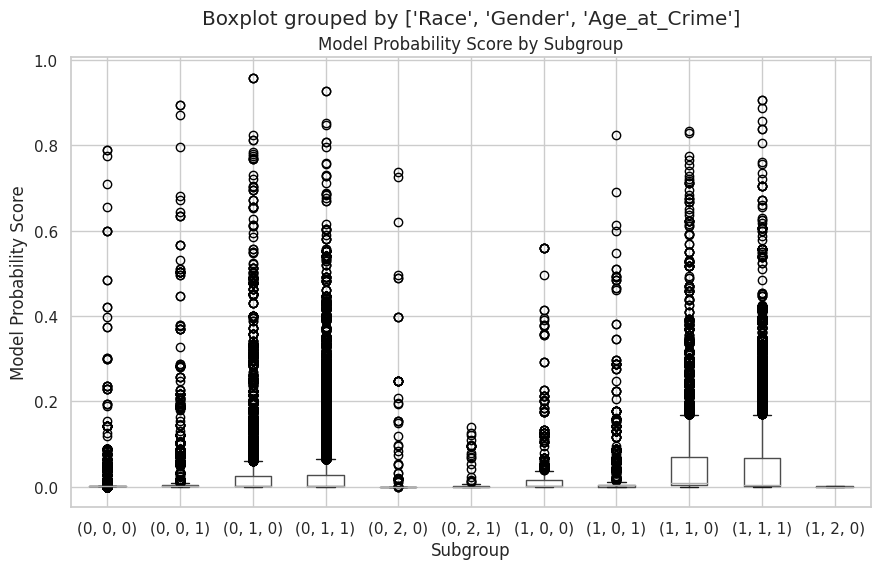

In [ ]:
# Boxplot
results.boxplot(column="model_probability", by=["Race", "Gender", "Age_at_Crime"], figsize=(10, 6))

plt.xlabel("Subgroup")
plt.ylabel("Model Probability Score")
plt.title("Model Probability Score by Subgroup")
plt.show()

(0,1,0), (0,1,1), (1,1,0), and (1,1,1) have the highest values. All of those have in common that their second value is gender. 1 stands for male here. This indicates that out of all the different demographic information, gender is the best indicator of what decision a judge will make. Moreover, it indicates that males are way more likely to be detained. Moreover, the (1,1,0), and (1,1,1) have less very low values. The commonality here lies in the first value being 1, which stands for being black. This means that the model is less likely to not assign arriagnment to black people than non black people.

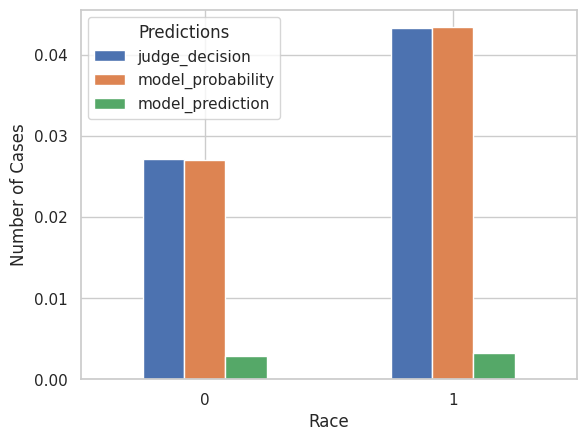

In [ ]:
race_decisions = results.groupby(["Race"]).agg({"judge_decision": "mean", "model_probability": "mean", "model_prediction": "mean"}).reset_index()
race_decisions.plot.bar(x="Race")
plt.xticks(rotation=0)
plt.xlabel("Race")
plt.ylabel("Number of Cases")
plt.legend(title="Predictions")
plt.show()

This graph enables one to see virtually whta I explained in one of the prior cells. Judges as well as the model predict a higher likelihood of getting detained if one is black compared to if someone is not black. 

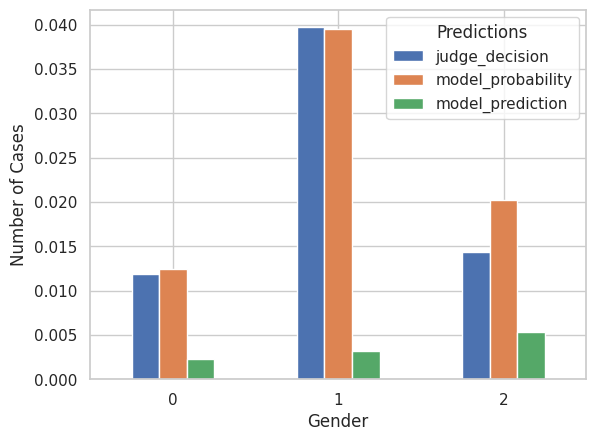

In [ ]:
race_decisions = results.groupby(["Gender"]).agg({"judge_decision": "mean", "model_probability": "mean", "model_prediction": "mean"}).reset_index()
race_decisions.plot.bar(x="Gender")
plt.xticks(rotation=0)
plt.xlabel("Gender")
plt.ylabel("Number of Cases")
plt.legend(title="Predictions")
plt.show()

In this graph, one can see the stark differences in likelihood of detainment based on gender. Males are almost four times as likely to face detainment than females. This might be due to male individuals appearing more harmful (especially physically). All othe genders like between femals and male. The model assigns a higher likelihood of these individuals being held in custody than the judge decision indicates. It is hard to hypothesize why this is because it is not entirely clear whether 2 indicates that these individuals are non-binary or whether it represents a lack of reporting.  

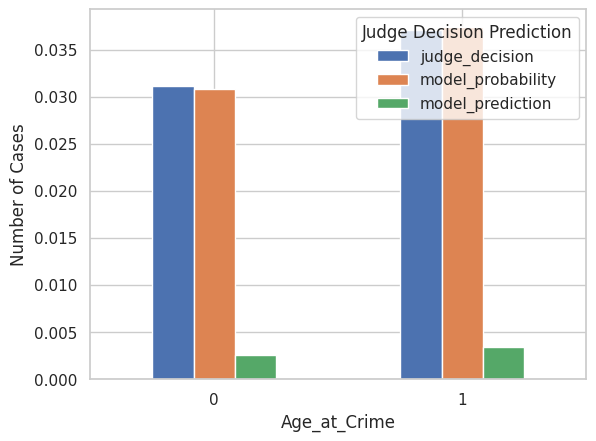

In [ ]:
race_decisions = results.groupby(["Age_at_Crime"]).agg({"judge_decision": "mean", "model_probability": "mean", "model_prediction": "mean"}).reset_index()
race_decisions.plot.bar(x="Age_at_Crime")
plt.xticks(rotation=0)
plt.xlabel("Age_at_Crime")
plt.ylabel("Number of Cases")
plt.legend(title="Judge Decision Prediction")
plt.show()

Although the age does not seem to play a significant role, one can certainly tell from these graphs that one is more likely to face detainment if this individual is older than the median. This could be due to judges being more forgiving for younger individuals, who might act more erratic due to their age.

<Axes: xlabel='model_probability', ylabel='judge_decision'>

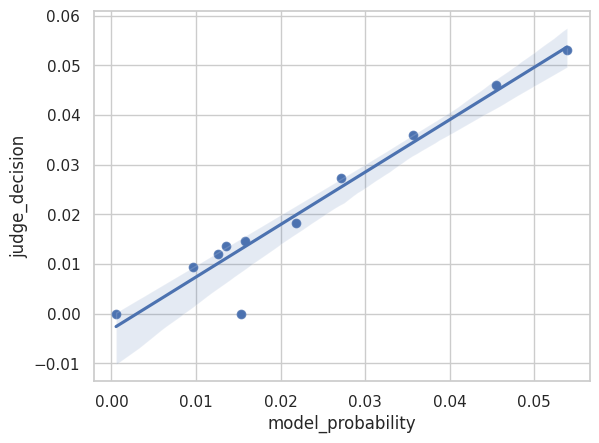

In [ ]:
sns.scatterplot(x="model_probability", y="judge_decision", data=all_cases)
sns.regplot(x="model_probability", y="judge_decision", data=all_cases)

This graph indicates that the probability estimated by the model lines up very well with the judge decisions. This, in turn, indicates that the model works pretty well in general. 

In [ ]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=["prior_vfo_cnt", "prior_nonvfo_cnt", "prior_misd_cnt", "Top_Charge_at_Arraign_Violent_Felony_Ind", "Top_Arraign_Attempt_Indicator", "Top_Severity_at_Arraign", "Race", "Gender", "Age_at_Crime"])
forest_importances = forest_importances.sort_values(ascending=False)
forest_importances

Top_Severity_at_Arraign                     0.291437
prior_nonvfo_cnt                            0.202511
prior_misd_cnt                              0.201835
Top_Charge_at_Arraign_Violent_Felony_Ind    0.105068
prior_vfo_cnt                               0.090157
Gender                                      0.030711
Race                                        0.029171
Age_at_Crime                                0.025456
Top_Arraign_Attempt_Indicator               0.023653
dtype: float64

The three highest values are 0.29, 0.20, and 0.20. These respetively translate to Top_Severity_at_Arraign, prior_nonvfo_cnt, and prior_misd_cnt. It makes sense that Top_Severity_at_Arraign and prior_nonvfo_cnt are among the top three since they already had the highest correlation with the y variable earlier. I assume that prior_vfo_cnt dropped down because it is somewhat related to prior_nonvfo_cnt since there are probably some individuals that have both. Hence, some of the earlier correlation that put prior_vfo_cnt into the top three is "eaten up" by prior_nonvfo_cnt, which, in turn, causes it to drop down. The third one is prior_misd_cnt. Similar to earlier logic, a judge is probably more prone to keep someone detained if they have already committed a crime earlier because they are more likely to reoffend. It makes sense that prior_misd_cnt is below prior_nonvfo_cnt because harsher crimes make it more likely that someone should be detained. 

In [ ]:
# VI A

results_sorted = results.sort_values(by="model_probability", ascending=False)

riskiest_index = int(len(results_sorted) * 0.01)
least_risky_index = int(len(results_sorted) * 0.99)
riskiest_defendants = results_sorted.iloc[:riskiest_index]
least_risky_defendants = results_sorted.iloc[least_risky_index:]
avg_risk_score_riskiest = riskiest_defendants["model_probability"].mean()
avg_risk_score_least_risky = least_risky_defendants["model_probability"].mean()

print("Average risk score for the riskiest 1% of defendants:", avg_risk_score_riskiest)
print("Average risk score for the least risky 1% of defendants:", avg_risk_score_least_risky)

Average risk score for the riskiest 1% of defendants: 0.47293549155664405
Average risk score for the least risky 1% of defendants: 0.0


In [ ]:
detention_rate_riskiest = len(riskiest_defendants[riskiest_defendants["judge_decision"] == 1]) / len(riskiest_defendants)
detention_rate_least_risky = len(least_risky_defendants[least_risky_defendants["judge_decision"] == 1]) / len(least_risky_defendants)

print("Detention rate for riskiest 1% of defendants:", detention_rate_riskiest)
print("Detention rate for least risky 1% of defendants:", detention_rate_least_risky)

Detention rate for riskiest 1% of defendants: 0.5435005117707267
Detention rate for least risky 1% of defendants: 0.0


As one would have thought, the most risky defendants are significantly more likely than the least risky defendants to be detained. It appears, however, that judges detain more of the most risky defendants than they should according to the model. (The predicted 47 is lower than the actual 54) The judges do, however, appear to make very accurate predictions for the least risky percentile since it is 0, which is the same as the model. The difference between the model and the judges decision is, however, not extraordinarily large (7%). So although one could say that judges are slightly too harsh, saying that they are generally too harsh would probably be an overstatement.   

In [ ]:
# VI B

results["judge_correct"] = results["model_prediction"] == results["judge_decision"]
false_positives = results[(results["model_prediction"] == 1) & (results["judge_decision"] == 0)]
false_negatives = results[(results["model_prediction"] == 0) & (results["judge_decision"] == 1)]

In [ ]:
results.describe()

,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,Top_Charge_at_Arraign_Violent_Felony_Ind,Top_Arraign_Attempt_Indicator,Top_Severity_at_Arraign,Age_at_Crime,Gender,Race,model_probability,model_prediction,judge_decision
count,97767.000000,97767.000000,97767.000000,97767.000000,97767.000000,97767.000000,97767.000000,97767.000000,97767.000000,97767.000000,97767.000000,97767.000000
mean,0.186341,0.428703,1.687072,0.146818,0.020580,0.328679,0.492620,0.807512,0.429429,0.034069,0.002987,0.034061
std,0.473045,0.924390,2.938852,0.353927,0.141973,0.469736,0.499948,0.408502,0.494997,0.074039,0.054569,0.181386
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.001542,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.002285,0.000000,0.000000
75%,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.026786,0.000000,0.000000
max,2.000000,4.000000,10.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.958730,1.000000,1.000000


In [ ]:
guilty_according_to_model = results[results["model_prediction"] == 1]
guilty_according_to_model.describe()

,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,Top_Charge_at_Arraign_Violent_Felony_Ind,Top_Arraign_Attempt_Indicator,Top_Severity_at_Arraign,Age_at_Crime,Gender,Race,model_probability,model_prediction,judge_decision
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.0,292.000000
mean,0.760274,2.160959,4.219178,0.623288,0.304795,0.996575,0.565068,0.856164,0.462329,0.628340,1.0,0.753425
std,0.780385,1.261967,2.922817,0.485394,0.461111,0.058521,0.496599,0.379722,0.499435,0.107085,0.0,0.431757
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502870,1.0,0.000000
25%,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.540769,1.0,1.000000
50%,1.000000,2.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.601339,1.0,1.000000
75%,1.000000,3.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.694547,1.0,1.000000
max,2.000000,4.000000,10.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.958730,1.0,1.000000


In [ ]:
false_positives.describe()

,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,Top_Charge_at_Arraign_Violent_Felony_Ind,Top_Arraign_Attempt_Indicator,Top_Severity_at_Arraign,Age_at_Crime,Gender,Race,model_probability,model_prediction,judge_decision
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.0,72.000000,72.000000,72.000000,72.000000,72.0,72.0
mean,0.638889,2.263889,3.972222,0.680556,0.236111,1.0,0.583333,0.847222,0.527778,0.565503,1.0,0.0
std,0.737440,1.125793,3.057994,0.469533,0.427672,0.0,0.496466,0.362298,0.502731,0.053460,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.502870,1.0,0.0
25%,0.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.528946,1.0,0.0
50%,0.000000,2.000000,3.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,0.551108,1.0,0.0
75%,1.000000,3.000000,6.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,0.594691,1.0,0.0
max,2.000000,4.000000,10.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.711598,1.0,0.0


In terms of false positives, there is not a whole lot of difference in comparison to all the values for which the model predicted arraign, which makes sense because both share a lot of the same datapoints. The race value for the false positive is slighty higher, indicating that judges decided more often (wrongly) in favor of detainment for black people in comparison to non black people than what the model predicted. The race also had a higher value for the false_negatives compared to the model predcitions, indicating that judges more often decided (wrongly) in favor of detainment for non-black people than they should have according to the model. This goes directly against the cconlusion of the false positive. If anything one can draw the conclusion from this that the different biased decisions from judges balance each other. The gender value is higher for the false_negatives (approximately 94 versus 80), indicating that judges more often ruled in favor of detention for males when the model would have predicted to not assign them detention. (All statements here refer to the mean) As already alluded to earlier, this indicates that judges perceive males more risky than they are. (at least on a relative basis to females)

In [ ]:
false_negatives.describe()

,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,Top_Charge_at_Arraign_Violent_Felony_Ind,Top_Arraign_Attempt_Indicator,Top_Severity_at_Arraign,Age_at_Crime,Gender,Race,model_probability,model_prediction,judge_decision
count,3110.000000,3110.000000,3110.000000,3110.000000,3110.000000,3110.000000,3110.000000,3110.000000,3110.000000,3110.000000,3110.0,3110.0
mean,0.439550,1.109646,3.222186,0.478135,0.049518,0.936334,0.535370,0.938264,0.553055,0.173553,0.0,1.0
std,0.651133,1.255879,3.445737,0.499602,0.216981,0.244196,0.498828,0.247306,0.497257,0.121988,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001241,0.0,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.069573,0.0,1.0
50%,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.146432,0.0,1.0
75%,1.000000,2.000000,5.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.262711,0.0,1.0
max,2.000000,4.000000,10.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.500000,0.0,1.0
